In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from tira_utils import get_input_directory_and_output_directory, normalize_run
import pyterrier as pt
import pandas as pd
import os
import json
from tqdm import tqdm
from glob import glob
from pathlib import Path
from collections import Counter
import torch
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from PIL import Image
import transformers
from transformers import pipeline
from preselection import retrieve
from phrase_generation import generate_phrases
from typing import Tuple
from typing_extensions import Literal

Start PyTerrier with version=5.7, helper_version=0.0.7, no_download=True


PyTerrier 0.9.1 has loaded Terrier 5.7 (built by craigm on 2022-11-10 18:30) and terrier-helper 0.0.7

No etc/terrier.properties, using terrier.default.properties for bootstrap configuration.
/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


I will use a small hardcoded example located in /workspace/dataset23/.
The output directory is /tmp/


In [ ]:
seed = 0
transformers.set_seed(0)

In [2]:
input_dir, output_dir = get_input_directory_and_output_directory(default_input='/workspace/dataset23/')

I will use a small hardcoded example located in /workspace/dataset23/.
The output directory is /tmp/


In [3]:
Path('image_results').mkdir(exist_ok=True)

In [4]:
def load_queries_xml():
    file_name = glob(input_dir + '/*.xml')[0]
    
    topics = pd.read_xml(file_name)
    
    ret = pd.DataFrame()
    # https://github.com/terrier-org/pyterrier/issues/62\n",
    ret['query'] = topics['title'].apply(lambda i: "".join([x if x.isalnum() else " " for x in i]))
    ret['qid'] = topics['number']
    return ret

def load_queries_trecxml():
    file_name = glob(input_dir + '/*.xml')[0]
    topics = pt.io.read_topics(file_name, format='trecxml')
    return topics

def load_queries_jsonl():
    file_name = glob(input_dir + '/*.jsonl')[0]
    return pd.read_json(file_name, lines=True)

def load_queries():
    try:
        return load_queries_xml()
    except:
        pass
    
    try:
        return load_queries_trecxml()
    except:
        pass
    
    try:
        return load_queries_jsonl()
    except:
        pass
    
    raise Exception(f'Found no topics file. Got: {glob(input_dir + "/*")}')

In [5]:
classifier = pipeline("zero-shot-classification", model='/workspace/bart-large-mnli', accelerator="bettertransformer", device=0)

In [6]:
first_directory_len = len(glob(input_dir+'/images/*')[0].split('/')[-1])

# load image text
# We use some very baseline method to get a textual representation: we just use the text of the pages that contain the image.
def load_website_text(image_id):
    ret = ''
    for txt_file in glob(input_dir +'/images/' + image_id[:first_directory_len] + '/' + image_id + '/*/*/*/text.txt'):
        ret += '\n\n' + open(txt_file).read()
    return ret.strip()

def load_image_text(image_id):
    ret = ''
    for txt_file in glob(input_dir +'/images/' + image_id[:first_directory_len] + '/' + image_id + '/image-text.txt'):
        ret += '\n\n' + open(txt_file).read()
    return ret.strip()

Stance = Literal['pro', 'con', 'neutral']

def get_stance(text, query) -> Tuple[Stance, float]:
    if text == '':
        return 'neutral', 1
    labels = ["contra "+ query, "pro "+ query, "neutral "+ query]
    
    result = classifier(text, labels)
    # sorts the labels starting with the most likely
    if result["labels"][0].startswith("contra"):
        return "contra", result["scores"][0]
    elif result["labels"][0].startswith("pro"):
        return "pro", result["scores"][0]
    else: 
        return "neutral", result["scores"][0]

def get_website_stance(image_id, query) -> Tuple[Stance, float]:
    text = load_website_text(image_id)
    return get_stance(text, query)

def get_image_stance(image_id, query) -> Tuple[Stance, float]:
    text = load_image_text(image_id)
    return get_stance(text, query)

def get_stance_from_source(image_id, query, stance_source : Literal['website', 'image', 'both']) -> Tuple[Stance, float]:
    if stance_source == 'website':
        return get_website_stance(image_id, query)
    elif stance_source == 'image':
        return get_image_stance(image_id, query)
    elif stance_source == 'both':
        website_stance, website_score = get_website_stance(image_id, query)
        image_stance, image_score = get_image_stance(image_id, query)
        if website_stance == 'neutral' and image_stance == 'neutral':
            return 'neutral', 1
        if 'neutral' == image_stance or 'neutral' == website_stance:
            neutral_score = image_score if image_stance == 'neutral' else website_score

            other_score = image_score if image_stance != 'neutral' else website_score
            other_stance = image_stance if image_stance != 'neutral' else website_stance
            
            return other_stance, other_score / 2 + ((1 - neutral_score) / 2) / 2
        
        if image_stance == website_stance:
            return image_stance, image_score / 2 + website_score / 2
        
        return 'neutral', 1
            

def detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_ids, query, x, stance_source : Literal['website', 'image', 'both']):
    # get image ids from preranking
    # get image texts based on preranking 
    pro_imgs = {}
    contra_imgs = {}
    pro_ids = []
    contra_ids = []
    
    for image_id in image_ids:
        
        stance, score = get_stance_from_source(image_id, query, stance_source)
        
        # separate pro and con texts; sort out neutral texts
        if stance == "pro":
            pro_imgs[image_id] = score
        elif stance == "contra": 
            contra_imgs[image_id] = score
            
    # sort according to scores
    sorted_pro = dict(sorted(pro_imgs.items(), key=lambda x:x[1], reverse=True))
    sorted_contra = dict(sorted(contra_imgs.items(), key=lambda x:x[1], reverse=True))
    
    # return best x results for each side
    i = 0
    for key in sorted_pro:
        if i < len(sorted_pro.keys()) and i < x:
            pro_ids.append(key)
        else: 
            break
        i += 1
    i = 0
    for key in sorted_contra:
        if i < len(sorted_contra.keys()) and i < x:
            contra_ids.append(key)
        else: 
            break
        i += 1
        
    return pro_ids, contra_ids, sorted_pro, sorted_contra
# not sorted right

In [7]:
def load_image_paths(image_ids):
    image_paths = []
    
    for image_id in image_ids:
        image_paths.append(input_dir + '/images/' + image_id[:first_directory_len] + '/' + image_id + '/image.webp')
        
    return image_paths

In [8]:
def load_image_generator():
    model_id = "/workspace/stable-diffusion-v1-4"
    print('torch.cuda.is_available(): ', torch.cuda.is_available())
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16, revision="fp16").to('cuda')
    
    return pipe
    


def generate_image(pipe, prompt, isrealistic, image_name=None, guidance_scale=20, inference_steps=50):
    if isrealistic:
        final_prompt = "a photograph about the topic: " + prompt
    else:
        final_prompt = "an image in comic style about the topic: " + prompt
    
    print(final_prompt)
    
    image = None
    
    while image == None or not image.getbbox():
        image = pipe(final_prompt, guidance_scale=guidance_scale, num_inference_steps=inference_steps).images[0]
        # print(not image.getbbox())

    if image_name != None:
        image.save("image_results/" + image_name + ".png")
    else:
        return image
    
def show_image(image_name):
    image = Image.open("image_results/" + image_name + ".png")
    image.show()

In [9]:
def flann_index_kdtree_matcher(image1, image2):
    MIN_MATCH_COUNT = 10
    
    # Initiate SIFT detector
    sift = cv.SIFT_create()
    
    image1_gray = cv.cvtColor(image1, cv.COLOR_RGB2GRAY)
    image2_gray = cv.cvtColor(image2, cv.COLOR_RGB2GRAY)

    # find the keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(image1_gray, None)
    kp2, des2 = sift.detectAndCompute(image2_gray, None)
    
    if des1 is None or des2 is None:
        return [], 0
            
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)
    
    flann = cv.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1,des2,k=2)
    
    # Apply ratio test
    global good
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)
    
    if len(good) == 0:
        return [], 0
    
    most_common_keypoint_matches = Counter(x.trainIdx for x in good).most_common(1)[0]
    
    # single keypoint check for to many matches
    if most_common_keypoint_matches[1] > 10:
        return [], 0
            
    if len(good)>MIN_MATCH_COUNT:
        src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
        dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
        
        M, mask = cv.findHomography(src_pts, dst_pts, cv.RANSAC,5.0)
        
        if M is None:
            print("empty Homography on image")
            return [], 0
        
        matchesMask = mask.ravel().tolist()
        
        h,w, _ = image1.shape
        pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
        dst = cv.perspectiveTransform(pts,M)
        image2 = cv.polylines(image2,[np.int32(dst)],True,255,3, cv.LINE_AA)
             
    else:
        # print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
        matchesMask = None

    draw_params = dict(matchColor=(0, 255, 0),
                       singlePointColor=(255, 0, 0),
                       matchesMask=matchesMask,
                       flags=cv.DrawMatchesFlags_DEFAULT)
    
    img_matches = np.empty((max(image1.shape[0], image2.shape[0]), image1.shape[1]+image2.shape[1], 3), dtype=np.uint8)
    # img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, flags=cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    img3 = cv.drawMatches(image1, kp1, image2, kp2, good, img_matches, **draw_params)
    
    # plt.imshow(img3, ), plt.show()
    
    return img3, len(good)

In [10]:
def sort_images(images, dataframe):
    sorted_images = []
    
    for i in range(len(images)):
        image_id = dataframe["image_num"][i]
        sorted_images.append(images[image_id])
    
    return sorted_images


def rank_images(images, image_name):
    print("image_results/" + image_name)
    topic_img = cv.cvtColor(cv.imread("image_results/" + image_name), cv.COLOR_BGR2RGB)
    image_ids = []
    match_numbers = []
    img_num = 0

    for image in images:
        # print(img_num)
    
        if image.size <= 100000000:
            img, good_matches = flann_index_kdtree_matcher(topic_img, image.copy())
        
            image_ids.append(img_num)
            match_numbers.append(good_matches)
    
        img_num += 1

    image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframe), sorted_image_id_and_match_num_dataframe


def update_image_id_and_match_num_dataframe(image_id_and_match_num_dataframe, curr_image_id_and_match_num_dataframe):
    for i in range(len(image_id_and_match_num_dataframe)):
        image_id = image_id_and_match_num_dataframe.iloc[i]["image_id"]
        
        for j in range(len(curr_image_id_and_match_num_dataframe)): 
            if image_id == curr_image_id_and_match_num_dataframe.iloc[j]["image_id"]:
                image_id_and_match_num_dataframe.iloc[i]["match_num"] += curr_image_id_and_match_num_dataframe.iloc[j]["match_num"]
        
    return image_id_and_match_num_dataframe


def combined_image_ranking(images, old_image_ids, generated_image_names):
    image_id_and_match_num_dataframe = pd.DataFrame()
    
    for generated_image_name in generated_image_names:
        generated_image = cv.cvtColor(cv.imread("image_results/" + generated_image_name), cv.COLOR_BGR2RGB)
        image_ids = []
        match_numbers = []
        image_numbers = []
        
        for i in range(len(images)):
            if images[i].size <= 100000000:
                img, good_matches = flann_index_kdtree_matcher(generated_image, images[i].copy())
                
                image_numbers.append(i)
                image_ids.append(old_image_ids[i])
                match_numbers.append(good_matches)
        
        if image_id_and_match_num_dataframe.empty:
            image_id_and_match_num_dataframe = pd.DataFrame({"image_num": image_numbers, "image_id": image_ids, "match_num": match_numbers})
        else:
            curr_image_id_and_match_num_dataframe = pd.DataFrame({"image_id": image_ids, "match_num": match_numbers})
            image_id_and_match_num_dataframe = update_image_id_and_match_num_dataframe(image_id_and_match_num_dataframe, curr_image_id_and_match_num_dataframe)
    
    sorted_image_id_and_match_num_dataframe = image_id_and_match_num_dataframe.sort_values(by=['match_num'], ascending=False).reset_index(drop=True)
    
    return sort_images(images, sorted_image_id_and_match_num_dataframe), sorted_image_id_and_match_num_dataframe
    

In [11]:
def show_multiple_images(image_list, row_count, col_count, save_image_name=None):
    if len(image_list) < row_count:
        row_count = len(image_list)
    
    for i in range(0, len(image_list), row_count*col_count):
        fig = plt.figure(figsize=(20, 20), dpi=80)
    
    for j in range(0, row_count*col_count):
        fig.add_subplot(row_count, col_count, j+1)
        plt.imshow(image_list[i+j])
        
    if save_image_name != None:
        save_path = "image_results/" + save_image_name
        plt.savefig(save_path)
        
    plt.show()

In [12]:
def create_submission_format_with_dataframe(preselection_data, image_id_dataframe, stance_string, max_image_num, show_submission_format):
    submission_format = ""
    rank = 1
    
    if len(image_id_dataframe) < max_image_num:
        image_num = len(image_id_dataframe)
    else:
        image_num = max_image_num
    
    #print(preselection_data['docno'])
    
    for i in range(image_num):
        #print(image_id_dataframe["image_id"][i])
        image_data = preselection_data.loc[preselection_data['docno'] == image_id_dataframe["image_id"][i]]
        #print(image_data)
        
        query_id = image_data["qid"].values[0]
        stance = stance_string
        image_id = image_data["docno"].values[0]
        image_rank = rank
        image_score = image_num - (rank-1)
        method = "-"
        
        submission_format += (str(query_id) + " " + str(stance) + " " + str(image_id) + " " + str(image_rank) + " " + str(image_score) + " " + str(method) + "\n")
        
        rank += 1
        
    if show_submission_format:
        print(submission_format)
    
    return submission_format

In [ ]:
def pipe_rank_images(image_ids, preselection_data, stance_string, pipe, query, max_image_num, should_gen_new_images, show_images, show_submission_format):
    image_paths = load_image_paths(image_ids)
    images = [cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB) for image_path in image_paths]
    print("get images")
    
    realistic_image_name = "image_realistic_" + stance_string
    comic_image_name = "image_comic_" + stance_string
    
    if should_gen_new_images:
        generate_image(pipe, query, True, realistic_image_name)
        show_image(realistic_image_name)
        generate_image(pipe, query, False, comic_image_name)
        show_image(comic_image_name)
        print("images generated")
    
    realistic_image_name += ".png"
    comic_image_name += ".png"
    ranked_images, sorted_image_id_and_match_num_dataframe = combined_image_ranking(images, image_ids, [realistic_image_name, comic_image_name])
    print("ranking")

    submission_format = create_submission_format_with_dataframe(preselection_data, sorted_image_id_and_match_num_dataframe, stance_string, max_image_num, show_submission_format)
    print("submission")
    
    if show_images:
        show_multiple_images(ranked_images, (max_image_num), 1)
        print("showed images")
    
    return submission_format
    

def full_pipeline(pipe_id, query_with_qid, stance_string, sd_pipe,  max_image_num=10, should_gen_new_images=True, show_images=False, show_submission_format=True):
    local_query_with_qid = query_with_qid.copy()
    
    print(local_query_with_qid["query"].values[0])
    
    pos_query, con_query = generate_phrases([str(t) for t in local_query_with_qid["query"].values.tolist()], 'frequency')
    
    local_query_with_qid["query"].values[0] = pos_query[0]
    preselection_data_pro = retrieve(local_query_with_qid)
    image_docnos_pro = preselection_data_pro["docno"]
    
    local_query_with_qid["query"].values[0] = con_query[0]
    preselection_data_con = retrieve(local_query_with_qid)
    image_docnos_con = preselection_data_con["docno"]
    print("preselection")
    global pro_ids_image, con_ids_image
    if pipe_id == 0:
        # only preselection + image generation + best match
        submission_pipe1_pro = pipe_rank_images(image_docnos_pro, preselection_data_pro, "pro", sd_pipe, pos_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
        submission_pipe1_con = pipe_rank_images(image_docnos_con, preselection_data_con, "con", sd_pipe, con_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
        
        return submission_pipe1_pro, submission_pipe1_con
    
    if pipe_id == 1:
        # re-evaluate stance based on web text
        pro_ids_web, _, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_pro, pos_query[0], max_image_num, 'website')
        _, con_ids_web, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_con, con_query[0], max_image_num, 'website')
        submission_pipe2_pro = pipe_rank_images(pro_ids_web, preselection_data_pro, "pro", sd_pipe, pos_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
        submission_pipe2_con = pipe_rank_images(con_ids_web, preselection_data_con, "con", sd_pipe, con_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
        return submission_pipe2_pro, submission_pipe2_con
    
    if pipe_id == 2:
        # re-evaluate stance based on image text
        
        pro_ids_image, _, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_pro, pos_query[0], max_image_num, 'image')
        _, con_ids_image, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_con, con_query[0], max_image_num, 'image')
        print('pro_ids_web', pro_ids_image)
        submission_pipe3_pro = pipe_rank_images(pro_ids_image, preselection_data_pro, "pro", sd_pipe, pos_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
        submission_pipe3_con = pipe_rank_images(con_ids_image, preselection_data_con, "con", sd_pipe, con_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
        
        return submission_pipe3_pro, submission_pipe3_con
    
    if pipe_id == 3:
        # combine stance from web and image
        pro_ids_image, _, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_pro, pos_query[0], max_image_num, 'both')
        _, con_ids_image, _, _ = detect_stance_for_image_ids_and_return_best_x_results_for_each_side(image_docnos_con, con_query[0], max_image_num, 'both')
        print('pro_ids_web', pro_ids_image)
        submission_pipe4_pro = pipe_rank_images(pro_ids_image, preselection_data_pro, "pro", sd_pipe, pos_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
        submission_pipe4_con = pipe_rank_images(con_ids_image, preselection_data_con, "con", sd_pipe, con_query[0], max_image_num, should_gen_new_images, show_images, show_submission_format)
        
        return submission_pipe4_pro, submission_pipe4_con
        

In [14]:
diff_pipe = load_image_generator()

torch.cuda.is_available():  True


/opt/conda/lib/python3.7/site-packages/transformers/models/clip/feature_extraction_clip.py:31: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  FutureWarning,


In [15]:
queries = load_queries()

Are social networking sites good for our society?


BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 35.23q/s]


preselection


/opt/conda/lib/python3.7/site-packages/transformers/pipelines/base.py:1073: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  UserWarning,


get images
a photograph about the topic: be social networking sites society


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:07<00:00,  6.96it/s]


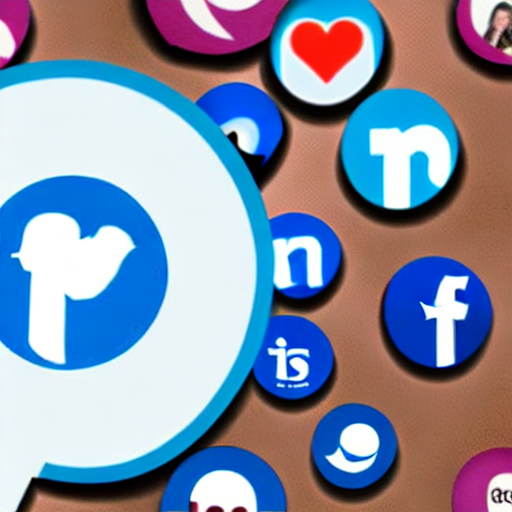

an image in comic style about the topic: be social networking sites society


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.20it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.71it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.87it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.85it/s]
Potential NSFW content was detected in one or more images. A black image will 

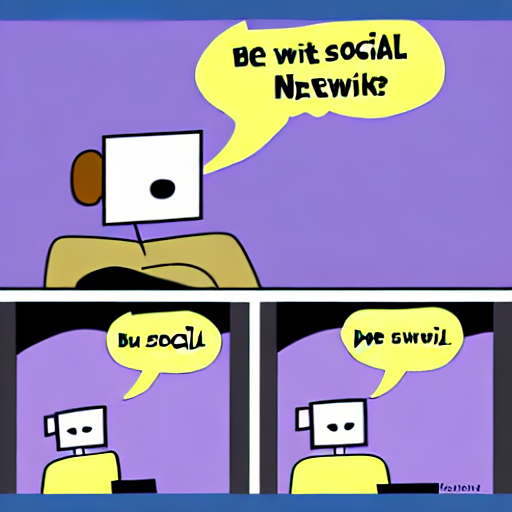

images generated


/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:1056: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cacher_needs_updating = self._check_is_chained_assignment_possible()


ranking
submission
get images
a photograph about the topic: not be social networking sites society


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.95it/s]


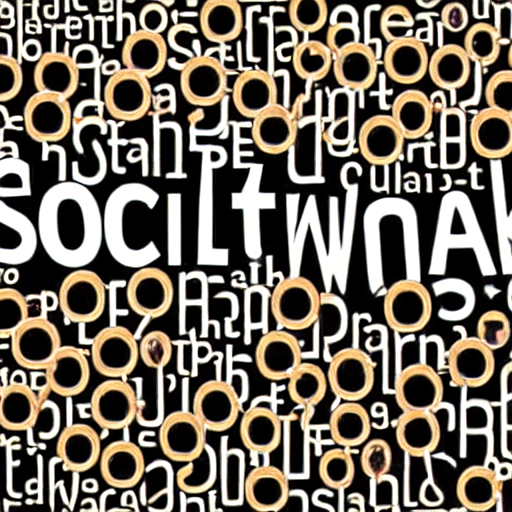

an image in comic style about the topic: not be social networking sites society


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.94it/s]


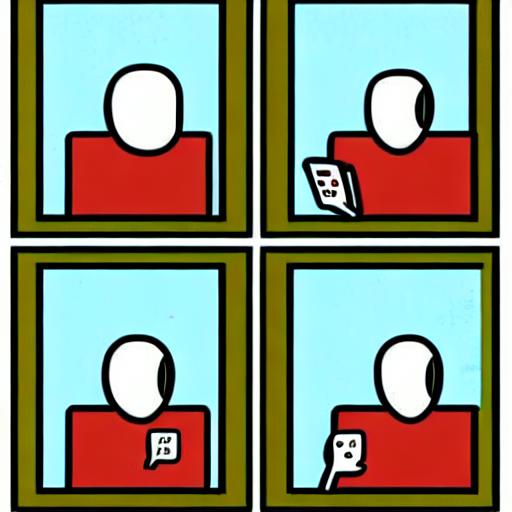

images generated
ranking
submission
Should the voting age be lowered?


BR(BM25): 100%|████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 57.87q/s]

preselection


get images
a photograph about the topic: lower voting age


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.96it/s]


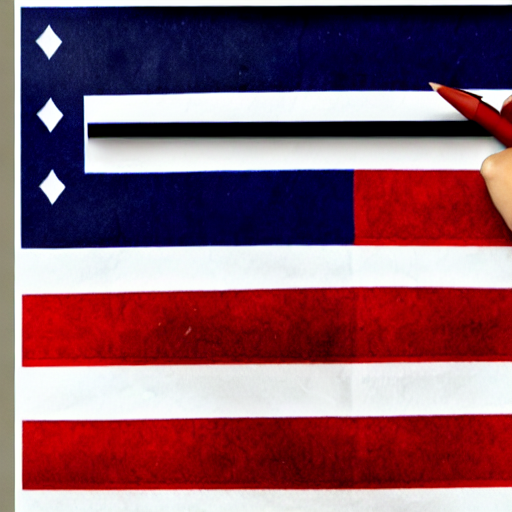

an image in comic style about the topic: lower voting age


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.97it/s]


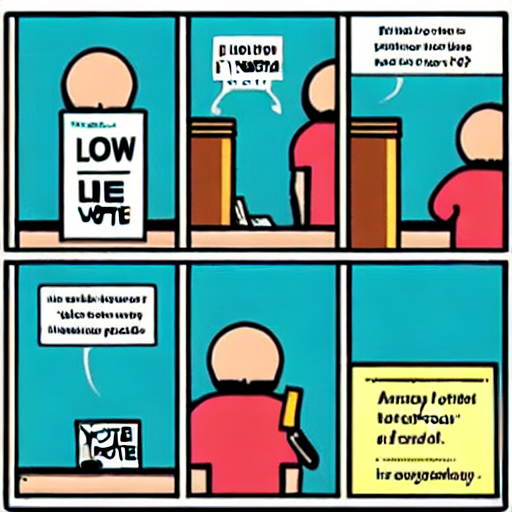

images generated
empty Homography on image
ranking
submission
get images
a photograph about the topic: not lower voting age


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:04<00:00, 12.36it/s]


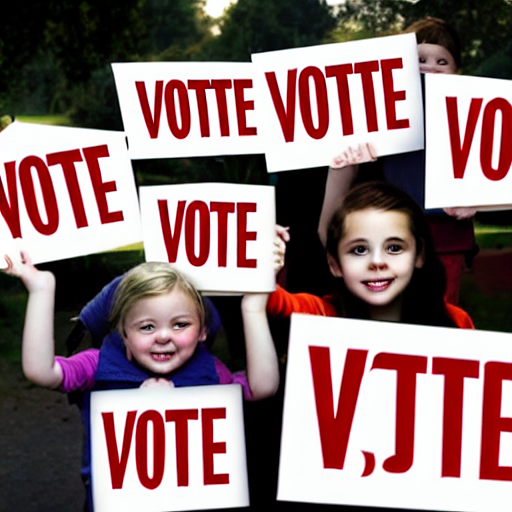

an image in comic style about the topic: not lower voting age


100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.92it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.91it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.90it/s]
Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.
100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 12.93it/s]
Potential NSFW content was detected in one or more images. A black image will 

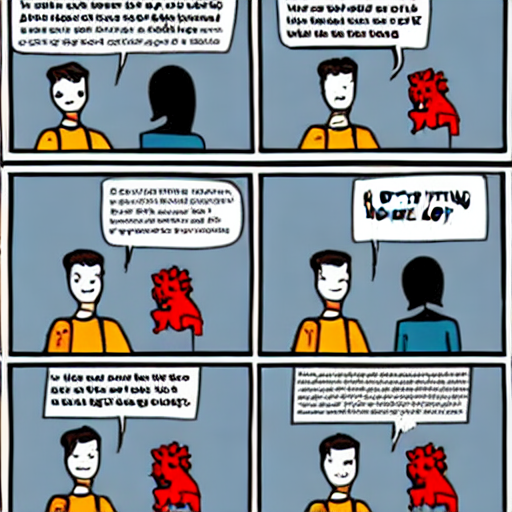

images generated
ranking
submission


In [16]:
with open(output_dir + '/run.txt', 'w') as output_file:
    max_queries = int(os.environ.get('MAX_QUERIES', 100))
    query_count = min(max_queries, queries.shape[0])
    pipeline_id = int(os.environ.get('PIPELINE_ID', 1))
    for i in range(query_count):
        selected_query_with_qid = queries.iloc[[i]]
        pro, con = full_pipeline(pipeline_id, selected_query_with_qid, "pro", diff_pipe, max_image_num=10, should_gen_new_images=True, show_images=False, show_submission_format=False)
        output_file.write(pro)
        output_file.write(con)

In [ ]:
print('finished pipepline')